Replication of Civil Wars Analyses for Yager Working Paper:
The Psychological Effects of Ethnic Targeting on Civil War

In [2]:
# Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
import os 
import statsmodels.api as sm
import statsmodels.formula.api as smf


Setting working directory: 

In [3]:
# Set WD
working_directory = "C:\\Users\\nyager\\Desktop\\YagerMLCode\\MachineLearning_Fall24\\CivilWars_Analyses"
os.chdir(working_directory)

# Confirm the change
print("Current Working Directory:", os.getcwd())

Current Working Directory: c:\Users\nyager\Desktop\YagerMLCode\MachineLearning_Fall24\CivilWars_Analyses


Load data: 

In [4]:
# Loading data
data = pd.read_csv("rawdata/data_groupyear.csv")

# Display the first few rows of the dataset
print(data.head())

   gwgroupid  year  countries_gwid onset_id    countryname  territorial_c  \
0     201000  2009               2      NaN  United States            NaN   
1     201000  2010               2      NaN  United States            NaN   
2     201000  2011               2      NaN  United States            NaN   
3     201000  2012               2      NaN  United States            NaN   
4     201000  2013               2      NaN  United States            NaN   

   intensity_level  active_dyads  active_dyads_change  ongoing_any  ...  \
0                0             0                  0.0            0  ...   
1                0             0                  0.0            0  ...   
2                0             0                  0.0            0  ...   
3                0             0                  0.0            0  ...   
4                0             0                  0.0            0  ...   

   l_yrs_excl  l_yrs_disc  pys_low2  pys_low3  wys_low2  wys_low3  wys_high2  \
0     

C:\Users\nyager\AppData\Local\Temp\ipykernel_13284\380121620.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("rawdata/data_groupyear.csv")


First analysis: Markov Model Replication

In [5]:
# Is the data sorted by group and time? 
data = data.sort_values(by=['gwgroupid', 'year'])

# Lagged variable generation (for analysis)
data['intensity_level_lag'] = data.groupby('gwgroupid')['intensity_level'].shift(1)

# Generating interaction terms
data['intensity_1_interaction'] = data['Target_Gov_l1'] * data['int_level1_lag']
data['intensity_2_interaction'] = data['Target_Gov_l1'] * data['int_level2_lag']


# Calculate transition matrix (basic example using pandas crosstab)
transition_matrix = pd.crosstab(data['intensity_level_lag'], data['intensity_level'], normalize='index')
print("Transition Matrix:\n", transition_matrix)

# Multinomial logistic regression (close to logit in Stata)
formula = 'intensity_level ~ intensity_1_interaction + intensity_2_interaction + peaceyrs_lowint + waryrs + ln_gdppc_l + ln_pop_l + family_warhist + cincidence_flag_l + status_excl'
mlogit_model = smf.mnlogit(formula, data=data)
mlogit_results = mlogit_model.fit()

# Displaying results
print(mlogit_results.summary())


Transition Matrix:
 intensity_level             0         1         2
intensity_level_lag                              
0.0                  0.988162  0.010967  0.000872
1.0                  0.285199  0.648014  0.066787
2.0                  0.083770  0.214660  0.701571
Optimization terminated successfully.
         Current function value: 0.104535
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:        intensity_level   No. Observations:                14527
Model:                        MNLogit   Df Residuals:                    14507
Method:                           MLE   Df Model:                           18
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.5433
Time:                        13:09:09   Log-Likelihood:                -1518.6
converged:                       True   LL-Null:                       -3325.0
Covariance Type:            nonrobust   LLR p-value:                     0

# Merging Data

In [6]:
# Load the main civwars dataset (data_groupyear)
data_groupyear = pd.read_csv("rawdata/data_groupyear.csv")

# Load Global Preferences Survey
gps_data = pd.read_stata("rawdata/GPS_Export.dta")

print(gps_data.columns)


Index(['countryname', 'risktaking'], dtype='object')


C:\Users\nyager\AppData\Local\Temp\ipykernel_13284\1778635771.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data_groupyear = pd.read_csv("rawdata/data_groupyear.csv")


Note it is called "countryname" and not "country" which can be confusing. 

Also, I was having issues with the GPS_Export.csv file so I decided to use the .dta file instead. 

In [7]:
# Sort GPS dataset by countryname and clean missing data
gps_data = gps_data.sort_values(by="countryname")
gps_data = gps_data[gps_data['risktaking'].notna()]  # Drop rows where 'risktaking' is NaN

# Ensure the data types match for merging
gps_data['countryname'] = gps_data['countryname'].astype(str)
data_groupyear['countryname'] = data_groupyear['countryname'].astype(str)

# Perform the one-to-many merge
merged_data = pd.merge(data_groupyear, gps_data, how="left", on="countryname")

# Handle missing data if necessary (drop rows where 'risktaking' is NaN after merging)
merged_data = merged_data[merged_data['risktaking'].notna()]

# Save the merged dataset to cleandata folder
merged_data.to_csv("cleandata/merged_data.csv", index=False)

# Inspect the merged dataset
print(merged_data.head())

# Tabulate occurrences of countryname (similar to 'tab countryname' in Stata)
country_counts = merged_data['countryname'].value_counts()
print(country_counts)


   gwgroupid  year  countries_gwid onset_id    countryname  territorial_c  \
0     201000  2009               2      NaN  United States            NaN   
1     201000  2010               2      NaN  United States            NaN   
2     201000  2011               2      NaN  United States            NaN   
3     201000  2012               2      NaN  United States            NaN   
4     201000  2013               2      NaN  United States            NaN   

   intensity_level  active_dyads  active_dyads_change  ongoing_any  ...  \
0                0             0                  0.0            0  ...   
1                0             0                  0.0            0  ...   
2                0             0                  0.0            0  ...   
3                0             0                  0.0            0  ...   
4                0             0                  0.0            0  ...   

   l_yrs_disc  pys_low2  pys_low3  wys_low2  wys_low3  wys_high2  wys_high3  \
0      

Merging done. 

# Markov Transition Models

Step 1: preparation

In [8]:
# Sort and prepare the data by group and time
data = merged_data.sort_values(by=["gwgroupid", "year"]).reset_index(drop=True)

# Creating lagged variables
data["intensity_level_lag"] = data.groupby("gwgroupid")["intensity_level"].shift(1)

# Creating interaction terms
interaction_vars = ["int_level1_lag", "int_level2_lag"]
for var in interaction_vars:
    data[f"{var}_interaction"] = data["Target_Gov_l1"] * data[var]

# Dropping rows with missing data for interaction vars. 
data = data.dropna(subset=["intensity_level_lag"])


Step 2: transition matrix

In [9]:
# Compute the transition matrix
transition_matrix = pd.crosstab(data["intensity_level_lag"], data["intensity_level"], normalize="index")
print("Transition Matrix:\n", transition_matrix)

Transition Matrix:
 intensity_level             0         1         2
intensity_level_lag                              
0.0                  0.990978  0.008248  0.000773
1.0                  0.221477  0.708054  0.070470
2.0                  0.121951  0.195122  0.682927


Step 3: multinomial logistic regression

In [10]:
print(data.columns)

Index(['gwgroupid', 'year', 'countries_gwid', 'onset_id', 'countryname',
       'territorial_c', 'intensity_level', 'active_dyads',
       'active_dyads_change', 'ongoing_any',
       ...
       'wys_low2', 'wys_low3', 'wys_high2', 'wys_high3', 'Target_Gov_l1pr',
       'Target_Gov_l1unpr', 'risktaking', 'intensity_level_lag',
       'int_level1_lag_interaction', 'int_level2_lag_interaction'],
      dtype='object', length=132)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Define predictors and the target variable
X = data[
    ["int_level1_lag_interaction", "int_level2_lag_interaction", "peaceyrs_lowint", 
     "waryrs", "ln_gdppc_l", "ln_pop_l", "family_warhist", 
     "cincidence_flag_l", "status_excl", "risktaking"]
]
y = data["intensity_level"]

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a multinomial logistic regression model
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2352
           1       0.65      0.69      0.67        71
           2       0.60      0.32      0.41        19

    accuracy                           0.98      2442
   macro avg       0.75      0.67      0.69      2442
weighted avg       0.98      0.98      0.98      2442



C:\Users\nyager\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Yager 2024 Regressions

In [12]:
# Set up and cleaning

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Dropping rows with missing gwgroupid
data = data.dropna(subset=["gwgroupid"])

# Unique ID for `year` and `gwgroupid`
data = data.sort_values(by=["year", "gwgroupid"])

# Drop risk-averse populations where `risktaking < 0` for specific analyses
risk_takers = data[data["risktaking"] >= 0]


In [14]:
# Simple linear regression
model1 = smf.ols("intensity_level ~ risktaking + Target_Gov_l5", data=data).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:        intensity_level   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     391.7
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          1.03e-161
Time:                        13:41:09   Log-Likelihood:                -287.82
No. Observations:                6799   AIC:                             581.6
Df Residuals:                    6796   BIC:                             602.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0433      0.003     13.998

In [140]:
# Logit regression
model2 = smf.mnlogit("intensity_level ~ Target_Gov_l5 + risktaking + status_excl", data=data).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.184988
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:        intensity_level   No. Observations:                 6799
Model:                        MNLogit   Df Residuals:                     6791
Method:                           MLE   Df Model:                            6
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                 0.09303
Time:                        10:34:10   Log-Likelihood:                -1257.7
converged:                       True   LL-Null:                       -1386.7
Covariance Type:            nonrobust   LLR p-value:                 7.973e-53
intensity_level=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.2330      0.184    -22.962      0.000      -4.594      -3.872
Target_G

In [141]:
# Logit regression with interaction term
data["interaction"] = data["Target_Gov_l5"] * data["risktaking"]
model3 = smf.mnlogit("intensity_level ~ Target_Gov_l5 + risktaking + interaction + status_excl", data=data).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.183471
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:        intensity_level   No. Observations:                 6799
Model:                        MNLogit   Df Residuals:                     6789
Method:                           MLE   Df Model:                            8
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.1005
Time:                        10:34:11   Log-Likelihood:                -1247.4
converged:                       True   LL-Null:                       -1386.7
Covariance Type:            nonrobust   LLR p-value:                 1.445e-55
intensity_level=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.2401      0.186    -22.843      0.000      -4.604      -3.876
Target_G

In [142]:
# Logit regression on risk-taking population only
model4 = smf.mnlogit("intensity_level ~ risktaking + Target_Gov_l5 + status_excl", data=risk_takers).fit()
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.220631
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:        intensity_level   No. Observations:                 2797
Model:                        MNLogit   Df Residuals:                     2789
Method:                           MLE   Df Model:                            6
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                  0.1705
Time:                        10:34:11   Log-Likelihood:                -617.10
converged:                       True   LL-Null:                       -743.95
Covariance Type:            nonrobust   LLR p-value:                 6.656e-52
intensity_level=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.7595      0.322    -11.665      0.000      -4.391      -3.128
risktak

In [143]:
for model in [model1, model2, model3, model4]:
    if not model.conf_int().columns.equals(pd.Index([0, 1])):
        conf_int = model.conf_int()
        conf_int.columns = [0, 1]  # Rename columns to match expected indices
        model.conf_int = lambda: conf_int

In [144]:
for model in [model1, model2, model3, model4]:
    if "const" in model.params.index:
        # Rename the "const" to "Intercept" for Stargazer compatibility
        params = model.params.rename({"const": "Intercept"})
        conf_int = model.conf_int()
        conf_int.index = conf_int.index.str.replace("const", "Intercept")

        # Patch the model's methods to use the renamed parameters
        model.params = params
        model.conf_int = lambda: conf_int


# EXPANSION: Decision Tree Model

target variable: intensity level

Splitting data, encoding categorical variables 

In [145]:
from sklearn.model_selection import train_test_split

# Select the relevant features and target variable
features = [
    "int_level1_lag_interaction", "int_level2_lag_interaction", "peaceyrs_lowint",
    "waryrs", "ln_gdppc_l", "ln_pop_l", "family_warhist", 
    "cincidence_flag_l", "status_excl", "risktaking"
]
target = "intensity_level"

# Drop missing values (or handle them appropriately)
data = data.dropna(subset=features + [target])

# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Creating a decision tree classifier 

In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize the decision tree classifier
tree = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model
tree.fit(X_train, y_train)

# Make predictions
y_pred = tree.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2325
           1       0.72      0.60      0.66        95
           2       0.44      0.77      0.56        22

    accuracy                           0.97      2442
   macro avg       0.72      0.79      0.73      2442
weighted avg       0.97      0.97      0.97      2442



Tree visualization

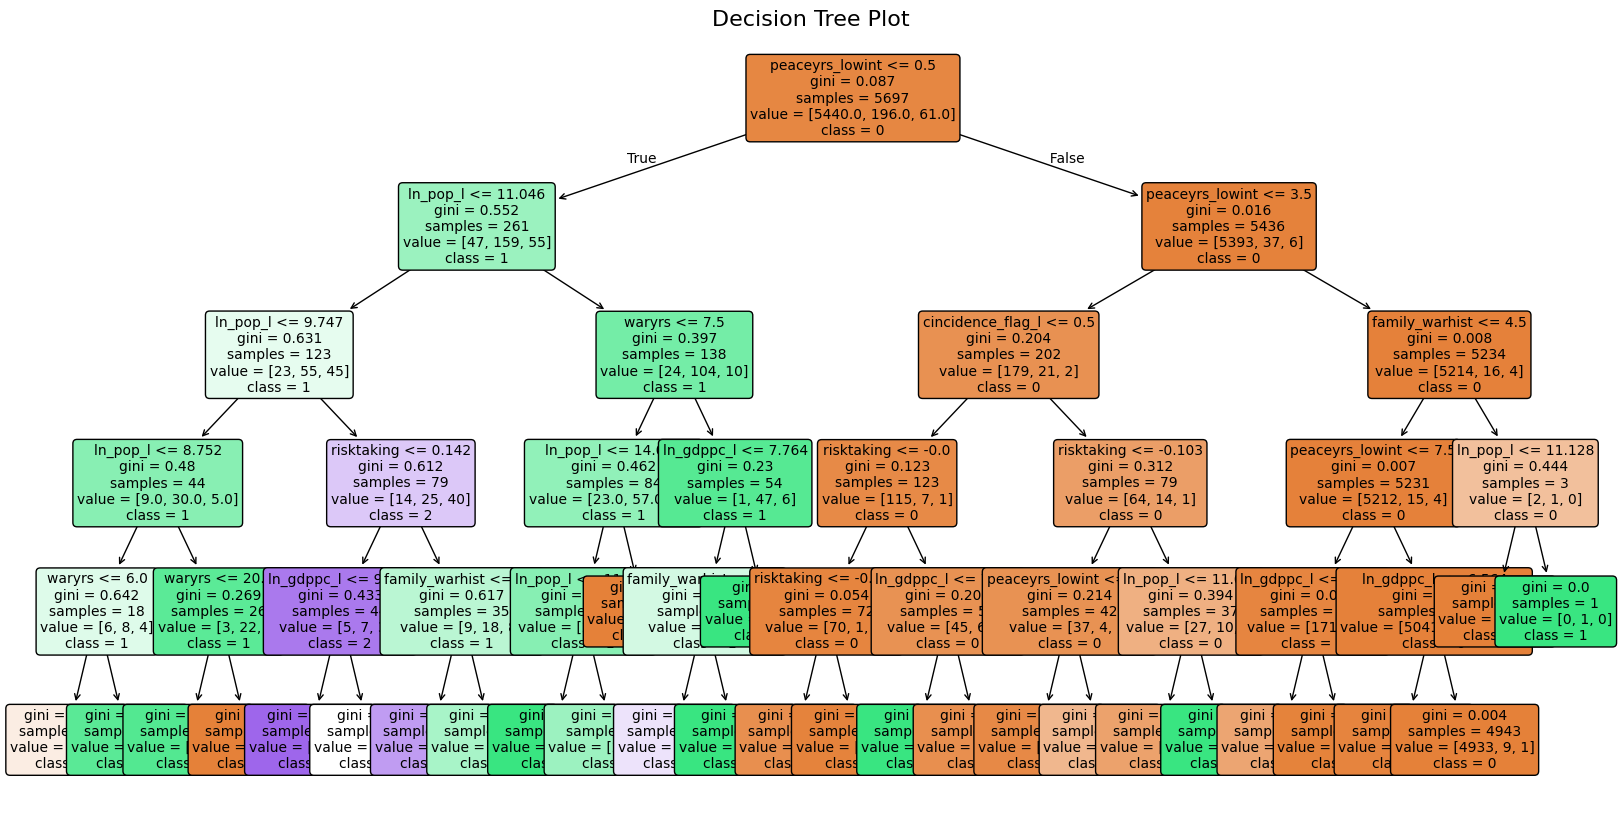

In [147]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Function to plot a fitted decision tree
def plot_fitted_tree(fitted_tree, feature_names, class_names=None, title="Decision Tree Plot"):
    plt.figure(figsize=(20, 10))  # Adjust the figure size
    plot_tree(
        fitted_tree,
        feature_names=feature_names,  # Feature names
        class_names=class_names,     # Class names if available
        filled=True,                 # Add colors
        rounded=True,                # Rounded edges for better readability
        fontsize=10                  # Font size for readability
    )
    plt.title(title, fontsize=16)   # Add a title
    plt.show()

# Replace 'fitted_tree' with your trained DecisionTreeClassifier
plot_fitted_tree(tree_model, features, class_names=[str(cls) for cls in tree_model.classes_])
